# Basic models

## Preprocess

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from common import TARGET, OBESITY_TYPES, DATASET_PATH, RANGE_INDEXES

# load dataset

dataset = pd.read_csv(DATASET_PATH)

# round to nearest integer for ranges
dataset[RANGE_INDEXES] = dataset[RANGE_INDEXES].apply(round).astype(np.int64)


X = dataset.drop(TARGET, axis="columns")
y = dataset[TARGET].map(
    {type: i for i, type in enumerate(OBESITY_TYPES)}
)  # transform targets into numbers


# split test/train (80%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100429021
)

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from common import flatten


CATEGORICAL_FEATURES = [
    (
        ["CAEC", "CALC"],  # indexes
        ["no", "Sometimes", "Frequently", "Always"],  # values
    ),
    (
        ["family_history_with_overweight", "FAVC", "SMOKE", "SCC"],
        ["yes", "no"],
    ),
    (["Gender"], ["Male", "Female"]),
    (
        ["MTRANS"],
        [
            "Automobile",
            "Motorbike",
            "Public_Transportation",
            "Walking",
            "Bike",
        ],
    ),
]


preprocessor = ColumnTransformer(
    transformers=[
        (
            "numeric",
            StandardScaler(),
            [
                "Age",
                "Height",
                "Weight",
                "FCVC",
                "NCP",
                "CH2O",
                "FAF",
                "TUE",
            ],
        ),
        (
            "categorical",
            OneHotEncoder(
                categories=list(
                    # python magic here
                    flatten(
                        [
                            [vals for _ in range(len(feats))]
                            for feats, vals in CATEGORICAL_FEATURES
                        ]
                    )
                )
            ),
            list(flatten([feats for feats, _ in CATEGORICAL_FEATURES])),
        ),
    ]
)

## Model definition

In [17]:
from dataclasses import dataclass
from typing import Any

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


@dataclass
class Model:
    name: str
    cls: Any
    kwargs: dict[str, Any] | None = None
    hyperparams: dict[str, list] | None = None


models = [
    Model(
        "K-Neighbours",
        KNeighborsClassifier,
        hyperparams={
            "n_neighbors": [1, 3, 5, 9, 11],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan", "minkowski"],
        },
    ),
    Model(
        "Naive Bayes",
        GaussianNB,
    ),
    Model(
        "Logistic Regression",
        LogisticRegression,
        kwargs={"max_iter": 10**4, "random_state": 100429021},
        hyperparams={
            "C": [10**i for i in range(-3, 4)],
            "solver": ["liblinear", "saga"],
            "penalty": ["l1", "l2"],
        },
    ),
    Model(
        "Random Forest",
        RandomForestClassifier,
        hyperparams={
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 40],
            "min_samples_split": [2, 5, 7],
        },
    ),
    Model(
        "SVM",
        SVC,
        hyperparams={
            "C": [10**i for i in range(-1, 3)],
            "kernel": ["linear", "rbf"],
        },
    ),
    Model(
        "XGBoost",
        XGBClassifier,
        kwargs={"eval_metric": f1_score},
        hyperparams={
            "n_estimators": [200, 400, 800],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 6],
        },
    ),
]

## Training and testing

------------
K-Neighbours
------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Training took 5.908 s
Best hyperparameters:
 - metric: manhattan
 - n_neighbors: 5
 - weights: distance

Results:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        87
           1       0.82      0.51      0.63        81
           2       0.80      0.79      0.79        85
           3       0.78      0.87      0.82        78
           4       0.86      0.87      0.86       113
           5       0.88      0.99      0.93        92
           6       1.00      1.00      1.00        98

    accuracy                           0.86       634
   macro avg       0.86      0.85      0.85       634
weighted avg       0.86      0.86      0.85       634

F1 score: 0.8481824994232365
-----------
Naive Bayes
-----------
Training took 0.011 s

Results:
              precision    recall  f1-score   support

           0       0.50      0.69   

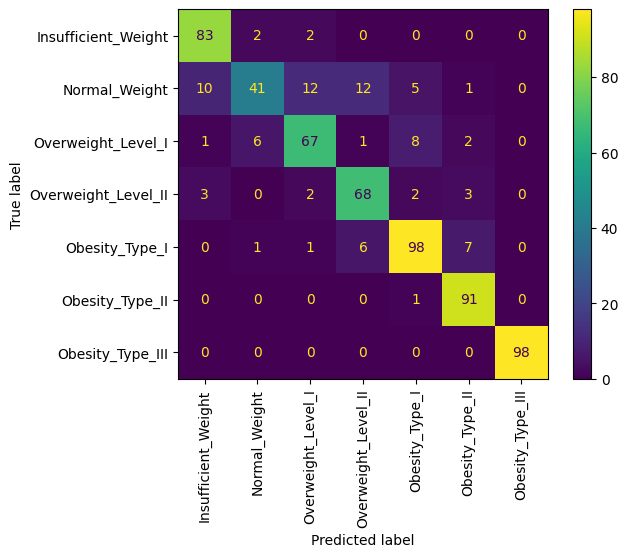

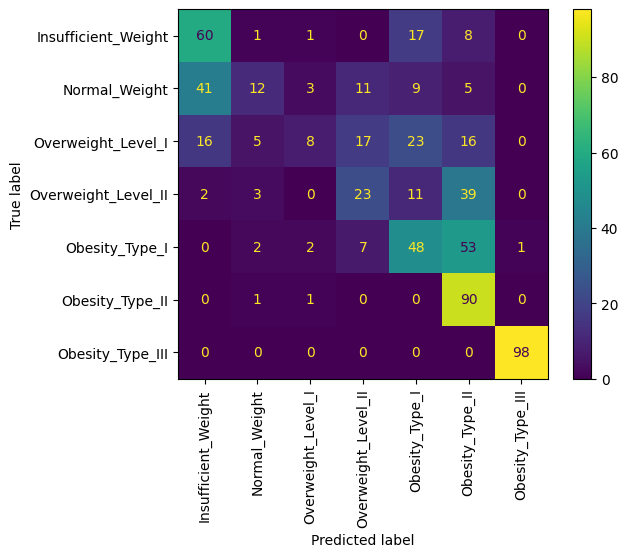

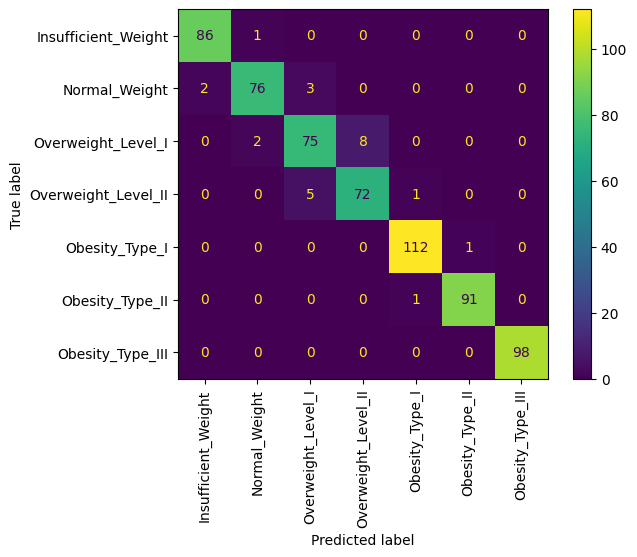

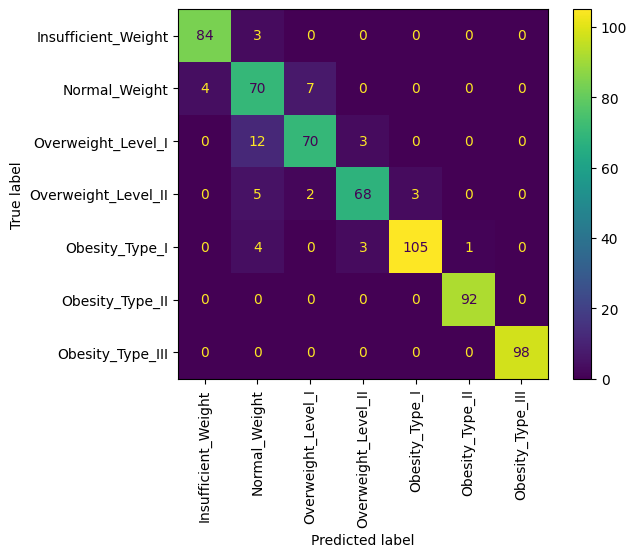

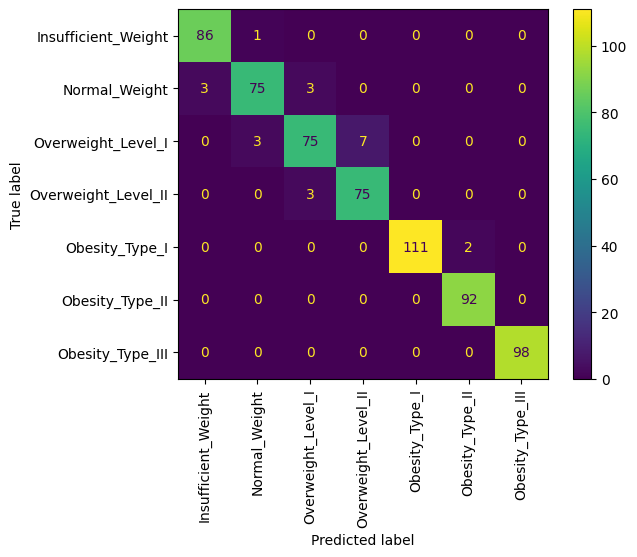

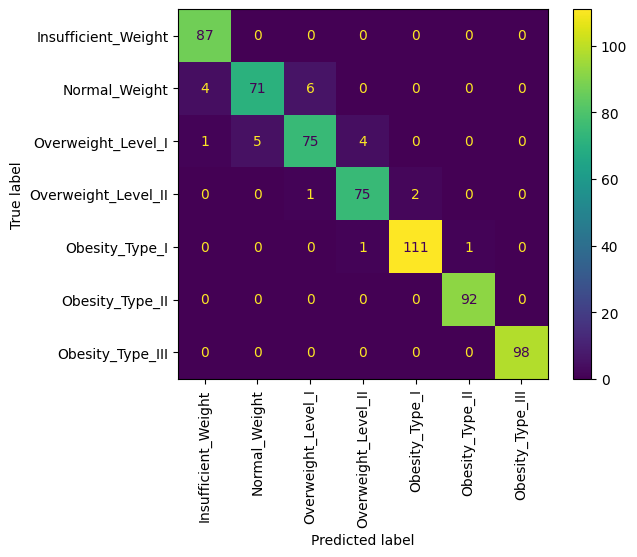

In [21]:
from time import perf_counter_ns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    f1_score,
    ConfusionMatrixDisplay,
)


results = pd.DataFrame()

for model in models:
    if model.kwargs is None:
        model.kwargs = {}

    # pipeline
    pipeline = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("cls", model.cls(**model.kwargs)),
        ]
    )

    print("-" * len(model.name))
    print(model.name)
    print("-" * len(model.name))

    if model.hyperparams:
        # setup parameter grid
        param_grid = {
            f"cls__{param}": val for param, val in model.hyperparams.items()
        }
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=5, scoring="f1_macro", verbose=1
        )

        cls = grid_search

    else:
        cls = pipeline

    # train
    tic = perf_counter_ns()
    cls.fit(X_train, y_train)
    time = perf_counter_ns() - tic
    print(f"Training took {10**-9 * time:.3f} s")

    if model.hyperparams:
        print("Best hyperparameters:")
        for param, val in grid_search.best_params_.items():
            print(f" - {param.removeprefix('cls__')}: {val}")

        cls = grid_search.best_estimator_

    # test
    y_pred = cls.predict(X_test)

    print("\nResults:")
    print(classification_report(y_test, y_pred))
    score = f1_score(y_test, y_pred, average="macro")
    print("F1 score:", score)

    # store results
    results = pd.concat(
        [
            results,
            pd.DataFrame(
                {"model": [model.name], "f1_macro": score, "time": time}
            ),
        ],
        ignore_index=True,
    )

    # plot confusion matrix
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=OBESITY_TYPES,
        xticks_rotation="vertical",
    )
    cm.figure_.savefig(
        f"../report/img/cm_{model.name}.svg", bbox_inches="tight"
    )  # store

results.to_csv("../data/results.csv", index=False)

## Results

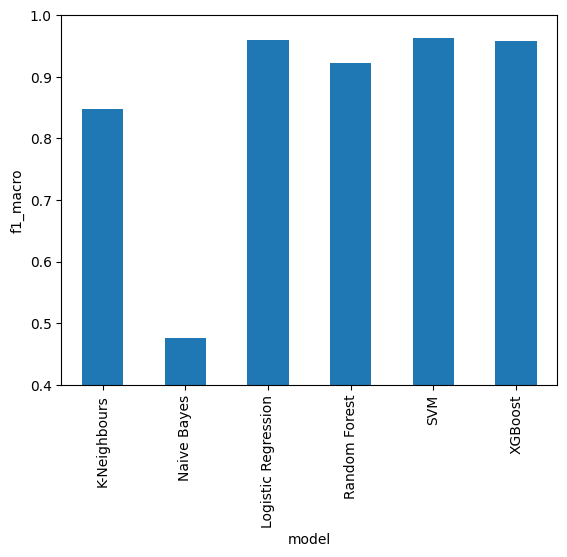

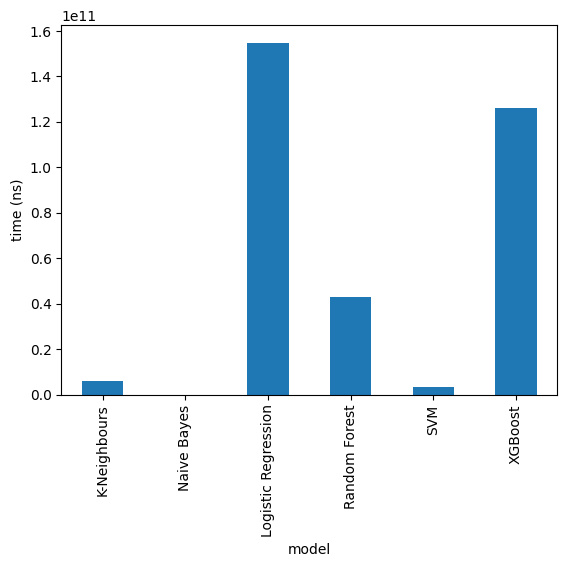

In [27]:
import matplotlib.pyplot as plt

# score
results.plot.bar(
    x="model",
    y="f1_macro",
    ylim=[0.4, 1],
    ylabel="f1_macro",
    legend=False
)
plt.savefig("../report/img/models_result.svg", bbox_inches="tight")


# time
results.plot.bar(
    x="model",
    y="time",
    ylabel="time (ns)",
    legend=False
    # ylim=[0.4, 1],
)
plt.savefig("../report/img/models_time.svg", bbox_inches="tight")